


# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils

# Transformations

In [3]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])


test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Load dataset

In [4]:
train = datasets.MNIST('./', train=True, download=True,transform=train_transforms)
test = datasets.MNIST('./', train=False, download=True,transform=test_transforms)

# Dataloaders: Test/Train dataset

In [7]:
batch_size = 15
learning_rate = 0.05

In [8]:
SEED = 3

# is cuda available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle = True, batch_size = batch_size, num_workers = 4,pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, ** dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics & Sample Data

## Mean & Std Values to Normalize dataset

In [12]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


# Basic Model

In [15]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) # input_size = 26 output_size = 24 receptive_field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7    
        
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 20 output_size = 10 receptive_field = 18
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 22 output_size = 20 receptive_field = 9        
        
        
#         self.pool1 = nn.MaxPool2d(2, 2) # input_size = 20 output_size = 10 receptive_field = 18

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 10 output_size = 8 receptive_field = 20
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 8 output_size = 6 receptive_field = 22
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_size = 6 output_size = 4 receptive_field = 24
        
        self.gap = nn.AvgPool2d(kernel_size=(5,5)) 
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(10),
        ) # input_size = 1 output_size = 1  receptive_field = 24
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)  
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [16]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
      BatchNorm2d-10            [-1, 8, 24, 24]              16
          Dropout-11            [-1, 8, 24, 24]               0
             ReLU-12            [-1, 8, 24, 24]               0
           Conv2d-13           [-1, 16, 22, 22]           1,152
      BatchNorm2d-14           [-1

#Training & Testing

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
def train(model, device, train_loader, optimizer, epoch,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    scheduler.step()
  train_epoch_end.append(train_acc[-1])
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test model

In [18]:
# from torch.optim.lr_scheduler import OneCycleLR
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)
# EPOCHS = 15
# for epoch in range(1,EPOCHS):
#     print("EPOCH:", epoch, "Learning Rate : ",scheduler.get_lr())
#     train(model, device, train_loader, optimizer, epoch, scheduler)
#     test(model, device, test_loader)


EPOCHS = 15


from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    test(model, device, test_loader)


<>:28: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:28: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  0%|          | 0/4000 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.24178136885166168 Batch_id=3999 Accuracy=91.18: 100%|██████████| 4000/4000 [00:37<00:00, 106.33it/s]  


Epoch: 0 LR: [0.015231063492185962]


/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:1205: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9785/10000 (97.85%)

EPOCH: 1


Loss=0.012568878941237926 Batch_id=3999 Accuracy=96.03: 100%|██████████| 4000/4000 [00:36<00:00, 110.19it/s] 

Epoch: 1 LR: [0.04366855450351416]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.12018387764692307 Batch_id=3999 Accuracy=96.79: 100%|██████████| 4000/4000 [00:34<00:00, 117.59it/s]   

Epoch: 2 LR: [0.07600483690453899]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.14619013667106628 Batch_id=3999 Accuracy=97.23: 100%|██████████| 4000/4000 [00:34<00:00, 116.20it/s]   

Epoch: 3 LR: [0.09710779233079525]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.1459967941045761 Batch_id=3999 Accuracy=97.55: 100%|██████████| 4000/4000 [00:37<00:00, 106.69it/s]    

Epoch: 4 LR: [0.09944098599223686]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.003023630939424038 Batch_id=3999 Accuracy=97.69: 100%|██████████| 4000/4000 [00:37<00:00, 106.22it/s]  

Epoch: 5 LR: [0.09504684036042728]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.06339854001998901 Batch_id=3999 Accuracy=97.99: 100%|██████████| 4000/4000 [00:37<00:00, 106.14it/s]   

Epoch: 6 LR: [0.08665010304866855]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.08425028622150421 Batch_id=3999 Accuracy=98.20: 100%|██████████| 4000/4000 [00:37<00:00, 105.62it/s]   

Epoch: 7 LR: [0.07499686101558521]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.0018344697309657931 Batch_id=3999 Accuracy=98.17: 100%|██████████| 4000/4000 [00:38<00:00, 105.01it/s] 

Epoch: 8 LR: [0.06112255595522705]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.09688349068164825 Batch_id=3999 Accuracy=98.37: 100%|██████████| 4000/4000 [00:38<00:00, 104.22it/s]   

Epoch: 9 LR: [0.04625998075859178]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.001521195867098868 Batch_id=3999 Accuracy=98.47: 100%|██████████| 4000/4000 [00:37<00:00, 105.83it/s]  


Epoch: 10 LR: [0.031729740455237444]


  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.000842372770421207 Batch_id=3999 Accuracy=98.63: 100%|██████████| 4000/4000 [00:37<00:00, 106.02it/s]  

Epoch: 11 LR: [0.01882291066102636]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.005418327637016773 Batch_id=3999 Accuracy=98.72: 100%|██████████| 4000/4000 [00:37<00:00, 105.73it/s]  

Epoch: 12 LR: [0.008686319843863788]



  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.005822605919092894 Batch_id=3999 Accuracy=98.83: 100%|██████████| 4000/4000 [00:38<00:00, 105.08it/s]  


Epoch: 13 LR: [0.002220648581550771]


  0%|          | 0/4000 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.07563510537147522 Batch_id=3999 Accuracy=98.90: 100%|██████████| 4000/4000 [00:38<00:00, 105.09it/s]   

Epoch: 14 LR: [4.001398747851388e-07]



Test set: Average loss: 0.0148, Accuracy: 9953/10000 (99.53%)



<ipython-input-18-9bc1512268f0>:28: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  [0.015237848701129195] [0.043689342994955464]


TypeError: list indices must be integers or slices, not float

# Ploting model result

Text(0.5, 1.0, 'Test Accuracy')

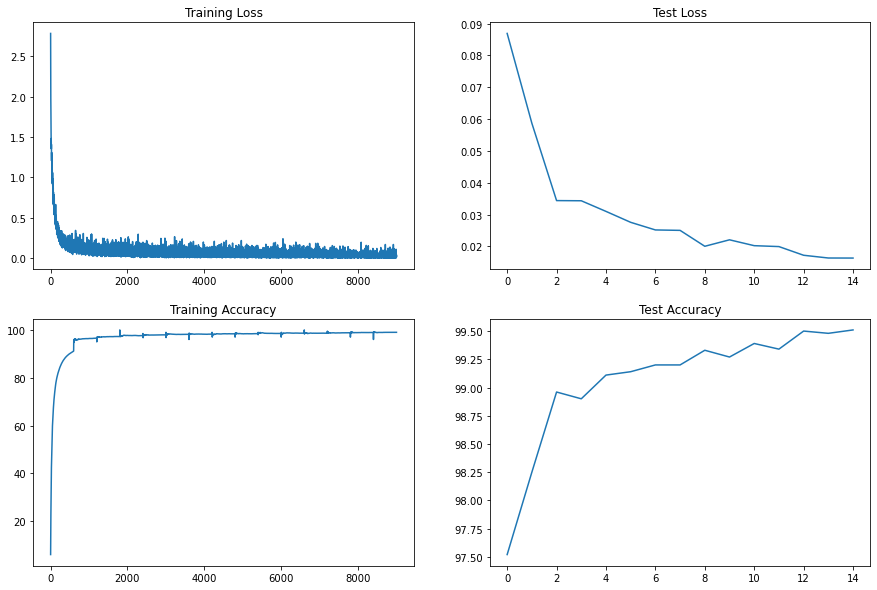

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

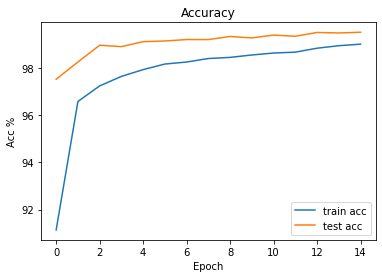

Best Training Accuracy :  99.005 %
Best Test Accuracy :  99.51 %


In [14]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('Accuracy')
plt.ylabel('Acc %')
plt.xlabel('Epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.show()
print("Best Training Accuracy : ",max(train_epoch_end[:20]),"%")
print("Best Test Accuracy : ",max(test_acc[:20]),"%")



### **Target**

1. Achieve a Model Testing  accuracy of  99.4%  at least 4 times .
2. Have a limit of 10k parameters in model.
3. Have a limit of 15 Epochs .

### **<u>Model 2</u>**


1. Set the structure of model.
2. Understanding the Statistics of Image and eye-balling the image.
3. Building model with Relu at every layer and softmax.
4. Trying various learning rate and batch size to obtain.
5. Trying to obtain constant increase in train and test accuracy.
6. Not undertrained and not overfitting.
7. Let's see the model performance for 20 epochs to understand where it is going.

### **Result**


Total params: 11,120
Trainable params: 11,120
Non-trainable params: 0


Best Training Accuracy :  98.93166666666667 %
Best Test Accuracy :  98.83 %

### Analysis

1. A constant increase in number of kernel or constant number of kernels per block.
2. Mnist is a simple dataset and does not need very large number of kernels or parameters.
3. Training Accuracy was not constant if no of kernels used is intermitently placed in model. This leads to a very zig-zag loss and test accuracy curve which was avoided and was made smooths.
4. 3 - 4 models were tested with different learning rate (0.15 - 0.35) and batch size(32 - 128) to achieve a acceptable model to work on.